In [15]:
import numpy as np
import pandas as pd
import torch 
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets, models
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from collections import OrderedDict
from tqdm.autonotebook import tqdm

In [29]:
from torch.utils.data import DataLoader, Dataset

In [16]:
from skimage import exposure

In [32]:
from glob import glob

In [48]:
from tqdm.notebook import tqdm
from PIL import Image

In [17]:
train_loc = "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/train/"
val_loc = "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/validation/"

In [19]:
data_transforms = {
    
    'train': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.CenterCrop((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation((-30,30)),
        transforms.ToTensor(),
        transforms.Normalize([0.5027,0.5027,0.5027],[0.2466, 0.2466, 0.2466])
        
    ]),
    
    'valid' : transforms.Compose([
        transforms.Resize((256,256)),
        transforms.CenterCrop((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5027,0.5027,0.5027],[0.2466, 0.2466, 0.2466])
    ])
    
}
    
    

In [20]:
data_dir = {
    "train" : "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/train/",
    "valid": "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/validation/",
    "test" : "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/test/"
}

label_csv = {"train": '/media/brats/DRIVE1/akansh/DeepXrays/Data/processed/train_labels.csv',
            "valid": "/media/brats/DRIVE1/akansh/DeepXrays/Data/processed/validation_labels.csv",
            "test": "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/submission.csv"}

In [30]:
class covid_dataset(Dataset):
    def __init__(self, image_loc, label_loc, transform, data_type = 'train'):
        filenames = []
        for root, dirs, files in os.walk(image_loc):
            for file in files:
                if file.endswith('.jpg') == True or file.endswith('.png') == True :
                    filenames.append(file)
        if data_type == 'train' or data_type == 'valid':
            self.full_filenames = glob(image_loc+'*/*.*')
        else:
            self.full_filenames = glob(image_loc+'*.*')
            
            
        label_df = pd.read_csv(label_loc)
        label_df.set_index("case", inplace = True)
        self.labels = [0 if label_df.loc[filename].values[0] == 2 else label_df.loc[filename].values[0] for filename in filenames]
        
        self.transform = transform
        
    def __len__(self):
        return len(self.full_filenames)
    
    def __getitem__(self,idx):
        image = Image.open(self.full_filenames[idx])
        image = image.convert('RGB')
        
        #Gamma 
                
        image = self.transform(image)
        return image, self.labels[idx]
        

In [34]:
valid_data = covid_dataset(image_loc = data_dir['valid'],
                          label_loc = label_csv['valid'],
                          transform = data_transforms['valid'],
                          data_type = 'valid')
train_data = covid_dataset(image_loc = data_dir['train'],
                          label_loc = label_csv['train'],
                          transform = data_transforms['train'],
                          data_type = 'train')

In [38]:
class_name = {'Abnormal': 0, 'normal': 1}
print(class_name)

{'Abnormal': 0, 'normal': 1}


In [40]:
trainloader = DataLoader(train_data,batch_size = 64,shuffle = True)
validloader = DataLoader(valid_data,batch_size = 32,shuffle = False)

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [42]:
model = models.densenet121(pretrained=True)

for param in model.parameters():
    param.requires_grad = True
    
model.classifier = nn.Sequential(OrderedDict([
    ('fcl1', nn.Linear(1024,256)),
    ('dp1', nn.Dropout(0.3)),
    ('r1', nn.ReLU()),
    ('fcl2', nn.Linear(256,32)),
    ('dp2', nn.Dropout(0.3)),
    ('r2', nn.ReLU()),
    ('fcl3', nn.Linear(32,3)),
    ('out', nn.LogSoftmax(dim=1)),
]))



In [44]:
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [45]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
schedular = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.1,patience = 5)
epochs = 50
valid_loss_min = np.Inf
max_val_acc = 0

In [46]:
def accuracy(y_pred,y_true):
    y_pred = torch.exp(y_pred)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))


In [49]:
train_loss_hist = []
valid_loss_hist = []
train_acc_hist = []
valid_acc_hist = []


for i in range(epochs):
    
    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0 
    
    
    model.train()
    
    for images,labels in tqdm(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        ps = model(images)
        loss = criterion(ps,labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_acc += accuracy(ps,labels)
        train_loss += loss.item()
        
    avg_train_acc = train_acc / len(trainloader)
    train_acc_hist.append(avg_train_acc)
    avg_train_loss = train_loss / len(trainloader)
    train_loss_hist.append(avg_train_loss)
        
    model.eval()
    with torch.no_grad():
        
        for images,labels in tqdm(validloader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            ps = model(images)
            loss = criterion(ps,labels)
            
            valid_acc += accuracy(ps,labels)
            valid_loss += loss.item()
            
            
        avg_valid_acc = valid_acc / len(validloader)
        valid_acc_hist.append(avg_valid_acc)
        avg_valid_loss = valid_loss / len(validloader)
        valid_loss_hist.append(avg_valid_loss)
        
        schedular.step(avg_valid_loss)
        
        if avg_valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).   Saving model ...'.format(valid_loss_min,avg_valid_loss))
            torch.save({
                'epoch' : i,
                'model_state_dict' : model.state_dict(),
                'optimizer_state_dict' : optimizer.state_dict(),
                'valid_loss_min' : avg_valid_loss
            },'Resnet101_epochs.pt')
            
            valid_loss_min = avg_valid_loss
            
        if avg_valid_acc >= max_val_acc:
            print('Validation accuracy Increased ({:.6f} --> {:.6f}).   Saving model ...'.format(max_val_acc,avg_valid_acc))
            torch.save({
                'epoch' : i,
                'model_state_dict' : model.state_dict(),
                'optimizer_state_dict' : optimizer.state_dict(),
                'valid_loss_min' : avg_valid_loss
            },'Resnet101_epochs_Best_Acc.pt')
            
            max_val_acc = avg_valid_acc
            
            
    print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1,avg_train_loss,avg_train_acc))
    print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1,avg_valid_loss,avg_valid_acc))


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.264002).   Saving model ...
Validation accuracy Increased (0.000000 --> 0.896701).   Saving model ...
Epoch : 1 Train Loss : 0.341267 Train Acc : 0.853086
Epoch : 1 Valid Loss : 0.264002 Valid Acc : 0.896701


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (0.264002 --> 0.229668).   Saving model ...
Validation accuracy Increased (0.896701 --> 0.907697).   Saving model ...
Epoch : 2 Train Loss : 0.261944 Train Acc : 0.895553
Epoch : 2 Valid Loss : 0.229668 Valid Acc : 0.907697


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.229751 Train Acc : 0.910698
Epoch : 3 Valid Loss : 0.413239 Valid Acc : 0.868056


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (0.229668 --> 0.189767).   Saving model ...
Validation accuracy Increased (0.907697 --> 0.926794).   Saving model ...
Epoch : 4 Train Loss : 0.220630 Train Acc : 0.914904
Epoch : 4 Valid Loss : 0.189767 Valid Acc : 0.926794


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.206921 Train Acc : 0.920183
Epoch : 5 Valid Loss : 0.220675 Valid Acc : 0.908565


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.190050 Train Acc : 0.928471
Epoch : 6 Valid Loss : 0.205960 Valid Acc : 0.924190


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.183297 Train Acc : 0.932218
Epoch : 7 Valid Loss : 0.282627 Valid Acc : 0.892361


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (0.189767 --> 0.187394).   Saving model ...
Validation accuracy Increased (0.926794 --> 0.931424).   Saving model ...
Epoch : 8 Train Loss : 0.180327 Train Acc : 0.933139
Epoch : 8 Valid Loss : 0.187394 Valid Acc : 0.931424


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (0.187394 --> 0.181758).   Saving model ...
Epoch : 9 Train Loss : 0.172811 Train Acc : 0.933807
Epoch : 9 Valid Loss : 0.181758 Valid Acc : 0.931134


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (0.181758 --> 0.176191).   Saving model ...
Validation accuracy Increased (0.931424 --> 0.936632).   Saving model ...
Epoch : 10 Train Loss : 0.166111 Train Acc : 0.939241
Epoch : 10 Valid Loss : 0.176191 Valid Acc : 0.936632


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 11 Train Loss : 0.163373 Train Acc : 0.937851
Epoch : 11 Valid Loss : 0.286870 Valid Acc : 0.881076


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 12 Train Loss : 0.158242 Train Acc : 0.941073
Epoch : 12 Valid Loss : 0.193492 Valid Acc : 0.927662


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (0.176191 --> 0.167854).   Saving model ...
Epoch : 13 Train Loss : 0.152874 Train Acc : 0.942946
Epoch : 13 Valid Loss : 0.167854 Valid Acc : 0.933160


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation accuracy Increased (0.936632 --> 0.940394).   Saving model ...
Epoch : 14 Train Loss : 0.151421 Train Acc : 0.944184
Epoch : 14 Valid Loss : 0.172272 Valid Acc : 0.940394


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 15 Train Loss : 0.151694 Train Acc : 0.941647
Epoch : 15 Valid Loss : 0.185611 Valid Acc : 0.935185


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 16 Train Loss : 0.146196 Train Acc : 0.945021
Epoch : 16 Valid Loss : 0.188340 Valid Acc : 0.929109


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (0.167854 --> 0.151730).   Saving model ...
Validation accuracy Increased (0.940394 --> 0.945602).   Saving model ...
Epoch : 17 Train Loss : 0.141461 Train Acc : 0.947231
Epoch : 17 Valid Loss : 0.151730 Valid Acc : 0.945602


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 18 Train Loss : 0.133466 Train Acc : 0.950266
Epoch : 18 Valid Loss : 0.161944 Valid Acc : 0.943287


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 19 Train Loss : 0.131984 Train Acc : 0.952587
Epoch : 19 Valid Loss : 0.164822 Valid Acc : 0.936921


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 20 Train Loss : 0.132050 Train Acc : 0.951732
Epoch : 20 Valid Loss : 0.223502 Valid Acc : 0.917245


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 21 Train Loss : 0.129132 Train Acc : 0.951864
Epoch : 21 Valid Loss : 0.566793 Valid Acc : 0.854745


  0%|          | 0/281 [00:00<?, ?it/s]

KeyboardInterrupt: 

Text(0, 0.5, 'Accuracy')

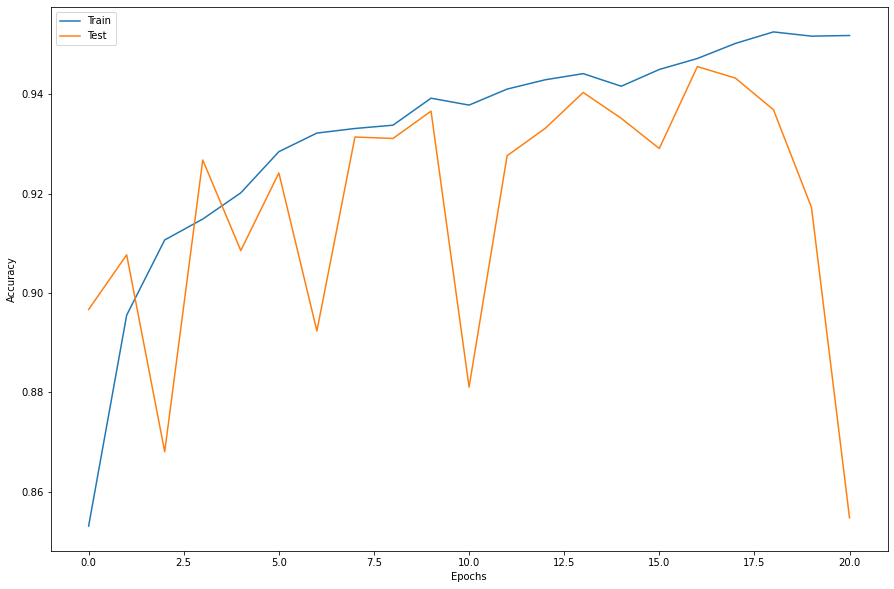

In [50]:
plt.figure(figsize=(15,10))
plt.plot(train_acc_hist, label = 'Train')
plt.plot(valid_acc_hist, label = 'Test')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

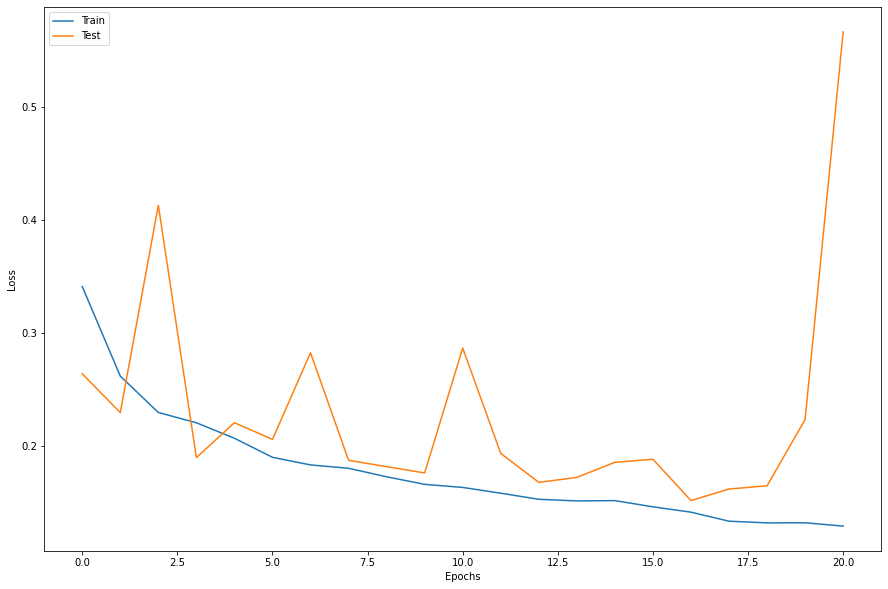

In [51]:
plt.figure(figsize=(15,10))
plt.plot(train_loss_hist, label = 'Train')
plt.plot(valid_loss_hist, label = 'Test')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

### Inference on Validation set of the best model

In [14]:
saved_model = torch.load("./baseline_2_model.pt")

In [15]:
model.load_state_dict(saved_model['model_state_dict'])

<All keys matched successfully>

In [16]:
model.eval()

test_loss = 0
test_acc = 0

for images,labels in tqdm(validloader):
    
    images = images.to(device)
    labels = labels.to(device)
    
    pred = model(images)
#     loss = criterion(pred,labels)
    
#     test_loss += loss.item()
    test_acc += accuracy(pred,labels)
    
# avg_test_loss = test_loss/len(validloader)
avg_test_acc = test_acc/len(validloader)


  0%|          | 0/108 [00:00<?, ?it/s]

In [17]:
print(f"Accuracy: {avg_test_acc.item()*100} %%!")

Accuracy: 91.14583134651184 %%!


#### Confusion Matrix

In [26]:
import seaborn as sns

In [27]:
nb_classes = 3
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in tqdm(enumerate(validloader)):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

0it [00:00, ?it/s]

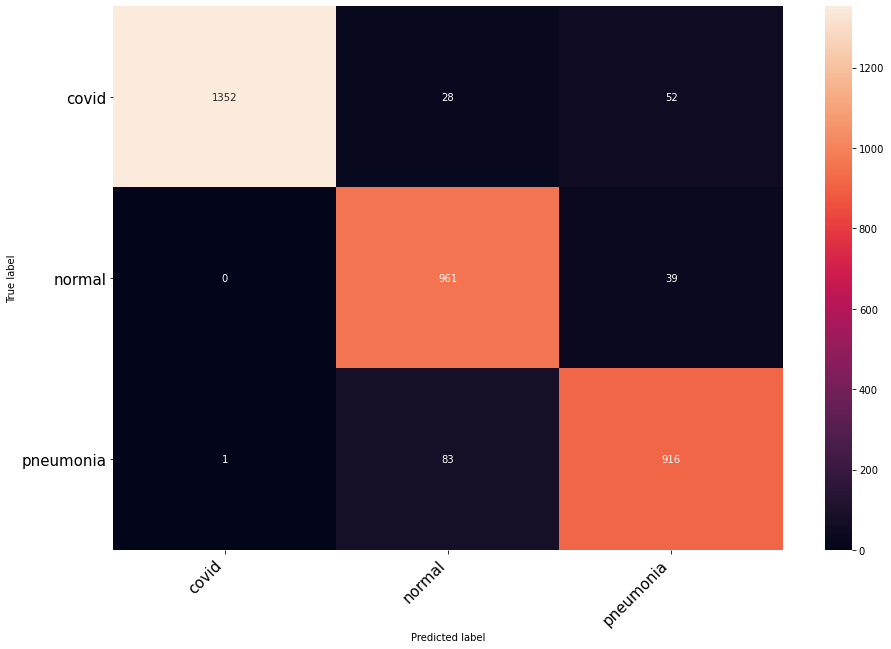

In [29]:
plt.figure(figsize=(15,10))

class_names = validloader.dataset.classes
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("/media/brats/DRIVE1/akansh/DeepXrays/Figures/baseline_resnet101_100epochs.png")